A note book for documenting qualitative results

In [2]:
import os
import matplotlib.pyplot as plt
import torchvision
import torch
import pandas as pd
import numpy as np

from models import get_inception_transform
from data_loaders import CUB_extnded_dataset,CUB_CtoY_dataset
from IPython.display import display
from utils.notebook import display_scrollable_dataframe,plot_sailency
from sailency import get_saliency_maps,saliency_score_part

c:\Users\Andre\anaconda3\envs\CBM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Settings for the experiment your running
data_set = 'test' 

#Make the dataset
transform = get_inception_transform(mode=data_set, methode= "center")

majority_config = {'CUB_dir':r'data/CUB_200_2011',
                'split_file':r'data/train_test_val.pkl',
                'use_majority_voting':True,
                'min_class_count':10,
                'return_visibility':False}

NoN_majority_config = {'CUB_dir':r'data/CUB_200_2011',
                'split_file':r'data/train_test_val.pkl',
                'use_majority_voting':False,
                'min_class_count':10,
                'return_visibility':False}

Non_majority_data_set = CUB_extnded_dataset(mode=data_set,config_dict=NoN_majority_config,transform=transform)


#Make the majority dataset and find the mask, we use CtoY dataset so we only need to loade the image ones 
Majority_dataset = CUB_CtoY_dataset(mode=data_set,config_dict=majority_config,transform=transform)
mask = Majority_dataset.concept_mask

#Make dataloader that return non standarized images
human_tansform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(299),torchvision.transforms.ToTensor()])
data_human = CUB_extnded_dataset(mode=data_set,config_dict=NoN_majority_config,transform=human_tansform)

#Define usefull variables
concept_names = data_human.consept_labels_names
class_names = data_human.class_labels_names
n_classes = data_human.n_classes
n_concepts = data_human.n_concepts

print(f"Number of classes: {n_classes}")
print(f"Number of concepts: {n_concepts}")

Number of classes: 200
Number of concepts: 312


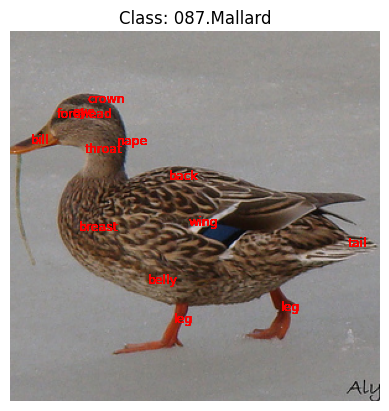

In [4]:
# Genrate the dataset
#picturer_idx = 400
picturer_idx = 2474
#picturer_idx = 2454 #Gadwell

img ,_,Y,coordinates = data_human.__getitem__(picturer_idx)

# Show the image and the coordinates of the concepts
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Class: {class_names[torch.argmax(Y)]}")
for i in range(len(coordinates)):
    if len(coordinates[i]) > 0:

        for x,y in coordinates[i]:
            #plt.plot(x,y,'ro')
            name=concept_names[i].split("_")[1]

            ofset = 0
            
            plt.text(x+ofset,y,name,fontsize=9,color='red')
    plt.axis('off')
            
plt.size=(50,50)
plt.show()

#Load the data
X, C, Y,coordinates = Non_majority_data_set.__getitem__(picturer_idx)
coordinates = [coordinates[i] for i in mask]
# Separate the concepts and their visibility only relevant if visibility is used and no majority voting is used
if len(C.shape) == 2:
    Concepts = C[0]
    Concepts_visiblity = C[1]
else:
    Concepts = C.tolist()
    Concepts_visiblity = [None]*len(C)

X = X.unsqueeze(0)


In [5]:
#Make concept dictionary
"""
concept_prediction = concept_prediction[0].detach()
concepts_propebability = torch.sigmoid(concept_prediction)
pridicted_class = Majority_dataset.concepts[Y]
#Apply mask
if concept_prediction.shape != Majority_C.shape:
    concept_prediction = concept_prediction[mask]
    concepts_propebability = concepts_propebability[mask]
"""


#Get ture labels 
_,NoN_Majority_C,_,_ = Non_majority_data_set.__getitem__(picturer_idx)
Majority_C,_ = Majority_dataset.__getitem__(picturer_idx)

#Find distribution of the concepts
Majority_concepts = Majority_dataset.concepts
NoN_Majority_concepts = np.array([Non_majority_data_set.concepts[y] for y in Non_majority_data_set.concepts.keys()])


Concept_dict={"Concept":concept_names,
                    "Label": NoN_Majority_C.numpy().astype(bool),
                    #"Label distribution": np.mean(NoN_Majority_concepts,axis=0)[mask],
                    "Majority Label": NoN_Majority_concepts[87].astype(bool),
                    #"Majority ditribution": np.mean(Majority_concepts,axis=0)
                    "Gadwall Majority": NoN_Majority_concepts[45].astype(bool)
                      }
    


  

312

In [6]:
#Test NoN majority joint model
model_path = r'evaluate_models\Joint_CKPT_NoMajority\best_Joint_model.pth'

#Load the model
Joint_model = torch.load(model_path,map_location=torch.device('cpu'),weights_only=False)
Joint_model.eval()
Joint_model.use_sigmoid = True

#Make prediction
C_hat,Y_hat = Joint_model(X)
C_hat_probability = torch.sigmoid(C_hat)
Y_hat = torch.softmax(Y_hat,dim=1)
#print(f"Predicted class: {class_names[Y_hat.argmax().item()]} true class: {class_names[Y.argmax().item()]} probability of true class: {Y_hat[0,Y.argmax()].item()}")
print(f"Predicted class: {class_names[Y_hat.argmax().item()]}, with {Y_hat[0,Y_hat.argmax()].item()} true class: {class_names[Y.argmax().item()]} probability of true class: {Y_hat[0,Y.argmax()].item()}")
print(Y_hat.argmax().item())
#Make Concept prediction and other stuff
weights = Joint_model.CtoY_model.linear.weight[Y.argmax().item()]
Concept_dict["Joint NoN-MV"] = np.round(C_hat_probability.detach().numpy()[0],2)
#display_scrollable_dataframe(pd.DataFrame(Concept_dict).sort_values(by=['Joint NonMajority prediction'],ascending=False))

Predicted class: 046.Gadwall, with 0.011247845366597176 true class: 087.Mallard probability of true class: 0.011011811904609203
45


In [12]:
# Test the concept model with NoN majority voting
XtoC_Model = torch.load(r'evaluate_models\Concepts_CKPT_NoMajority\best_XtoC_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model.eval()

CtoY_Model = torch.load(r'evaluate_models\Sequntial_NoMajority_end\best_CtoY_model.pth',map_location=torch.device('cpu'),weights_only=False)
CtoY_Model.eval()
CtoY_model = CtoY_Model.float()

#Make prediction
C_hat = XtoC_Model(X)
C_hat_probability = torch.sigmoid(C_hat)

Y_hat = torch.softmax(CtoY_Model(C_hat_probability),dim=1)

#print(f"Predicted class: {class_names[Y_hat.argmax().item()]} true class: {class_names[Y.argmax().item()]} probability of true class: {Y_hat[0,Y.argmax()].item()}")
#print(f"Predicted class: {class_names[Y_hat.argmax().item()]} true class: {class_names[Y.argmax().item()]} probability of true class: {Y_hat[0,Y.argmax()].item()}")
print(f"Predicted class: {class_names[Y_hat.argmax().item()]}, with {Y_hat[0,Y_hat.argmax()].item()} true class: {class_names[Y.argmax().item()]} probability of true class: {Y_hat[0,Y.argmax()].item()}")
#Make Concept prediction and other stuff
weights = CtoY_Model.linear.weight[Y.argmax().item()]

Concept_dict["Sequential NoN-MV"] = np.round(C_hat_probability.detach().numpy()[0],2)
#display_scrollable_dataframe(pd.DataFrame(Concept_dict).sort_values(by=['Majority Label',"Label"],ascending=False))

Predicted class: 046.Gadwall, with 0.9735161066055298 true class: 087.Mallard probability of true class: 2.6784750417618852e-08


In [40]:
#Small intervention expriment setting bill shape to corne instead of all pourpose
C_hat_probability[0,6]=0
C_hat_probability[0,7]=1
Y_hat = torch.softmax(CtoY_Model(C_hat_probability),dim=1)
print(f"Predicted class: {class_names[Y_hat.argmax().item()]}, with {Y_hat[0,Y_hat.argmax()].item()} true class: {class_names[Y.argmax().item()]} probability of true class: {Y_hat[0,Y.argmax()].item()}")
#Concept_dict["Sequential NoN-MV intervetnion"] = np.round(C_hat_probability.detach().numpy()[0][mask],2)

Predicted class: 119.Field_Sparrow, with 0.9953343272209167 true class: 087.Mallard probability of true class: 1.09827556771247e-10


In [12]:
mask

array([  1,   4,   6,   7,  10,  14,  15,  20,  21,  23,  25,  29,  30,
        35,  36,  38,  40,  44,  45,  50,  51,  53,  54,  56,  57,  59,
        63,  64,  69,  70,  72,  75,  80,  84,  90,  91,  93,  99, 101,
       106, 110, 111, 116, 117, 119, 125, 126, 131, 132, 134, 145, 149,
       151, 152, 153, 157, 158, 163, 164, 168, 172, 178, 179, 181, 183,
       187, 188, 193, 194, 196, 198, 202, 203, 208, 209, 211, 212, 213,
       218, 220, 221, 225, 235, 236, 238, 239, 240, 242, 243, 244, 249,
       253, 254, 259, 260, 262, 268, 274, 277, 283, 289, 292, 293, 294,
       298, 299, 304, 305, 308, 309, 310, 311])

In [13]:
C_hat_probability.shape

torch.Size([1, 312])

In [41]:
#Add the baslines
Concept_dict["NoN-MV Label distribution"] = np.mean(NoN_Majority_concepts,axis=0)[mask]
Concept_dict["MV label ditribution"] = np.mean(Majority_concepts,axis=0)


In [11]:
for k in Concept_dict.keys():
    print(k,len(Concept_dict[k]))

Concept 312
Label 312
Majority Label 312
Gadwall Majority 312
Joint NoN-MV 312
Sequential NoN-MV 112


In [13]:
Full_df=pd.DataFrame(Concept_dict)
Selected_df = Full_df[Full_df["Gadwall Majority"] != Full_df["Majority Label"]]

# add row 39 to selected
#Selected_df = pd.concat([Selected_df,Full_df.iloc[[39,8,51]]])

display_scrollable_dataframe(Selected_df)

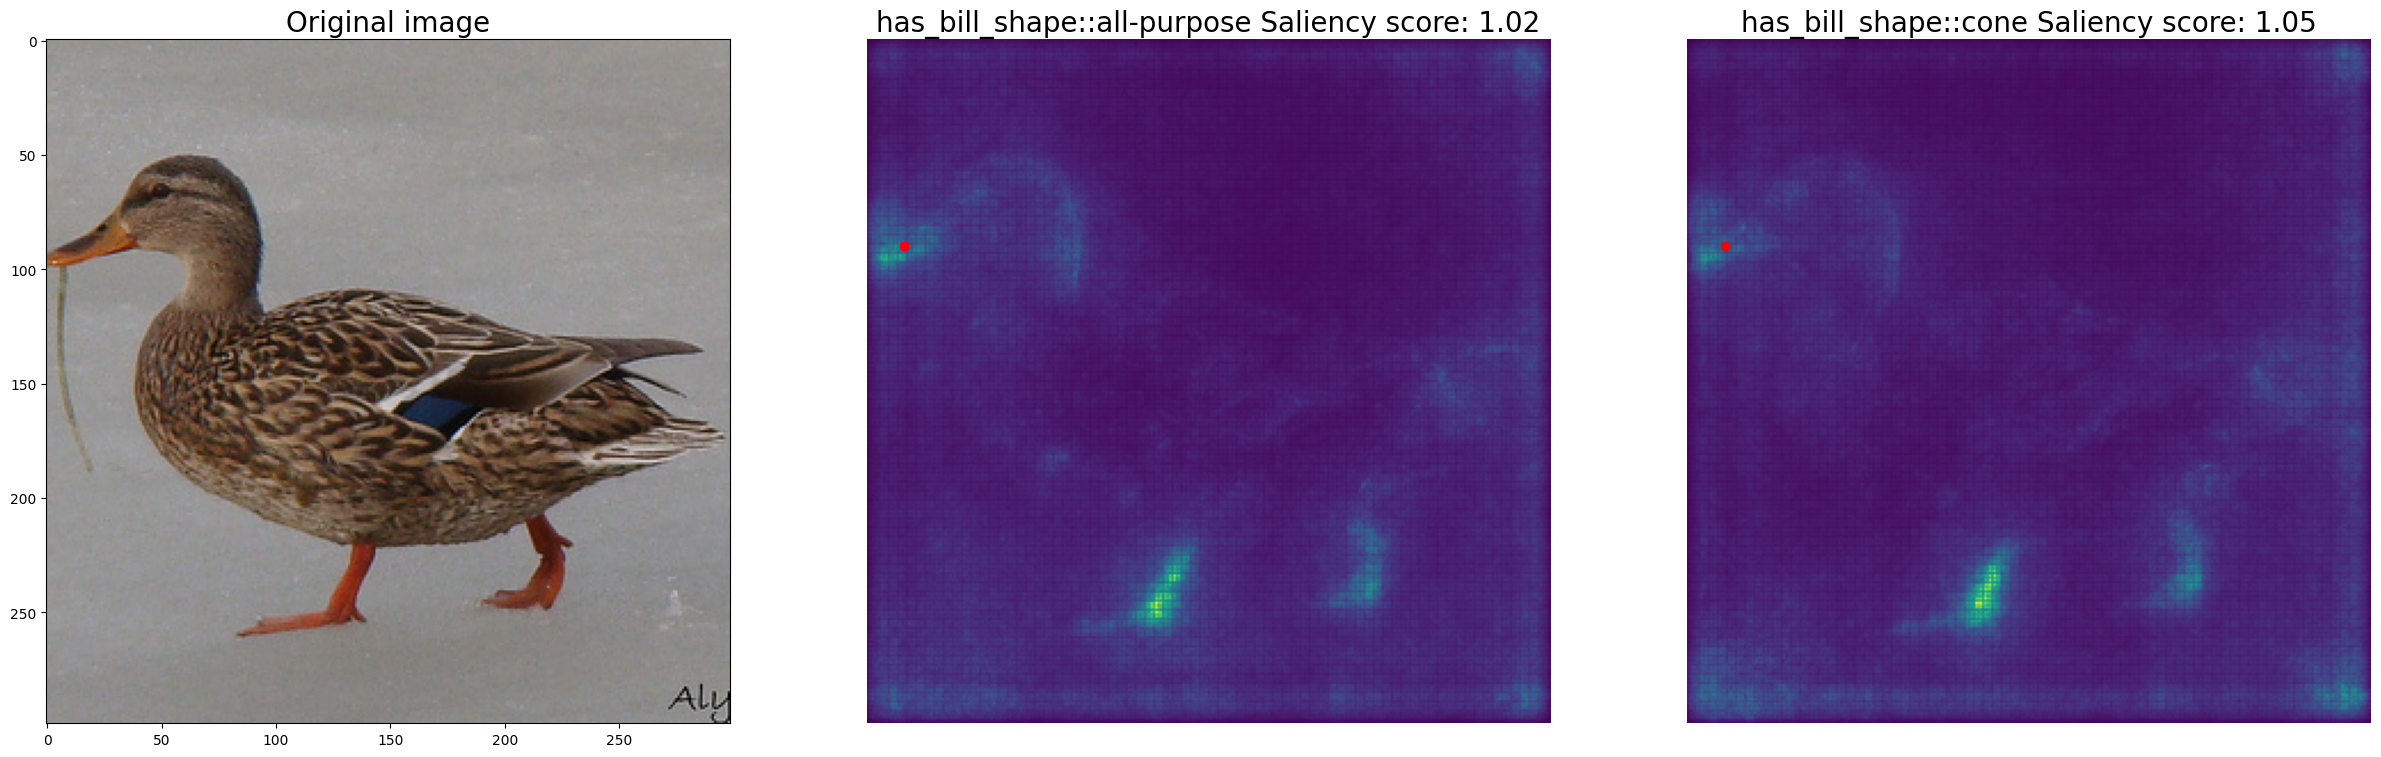

In [11]:
concept_list = [2,3]#,102,41]
Joint_model = torch.load(r'evaluate_models\Joint_CKPT_Majority\best_Joint_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model = Joint_model.XtoC_model
XtoC_Model.eval()
sailency_maps = get_saliency_maps(X,concept_list,XtoC_Model,method_type='noise_tunnel')

plot_sailency(img,sailency_maps,concept_list,concept_names,coordinates)

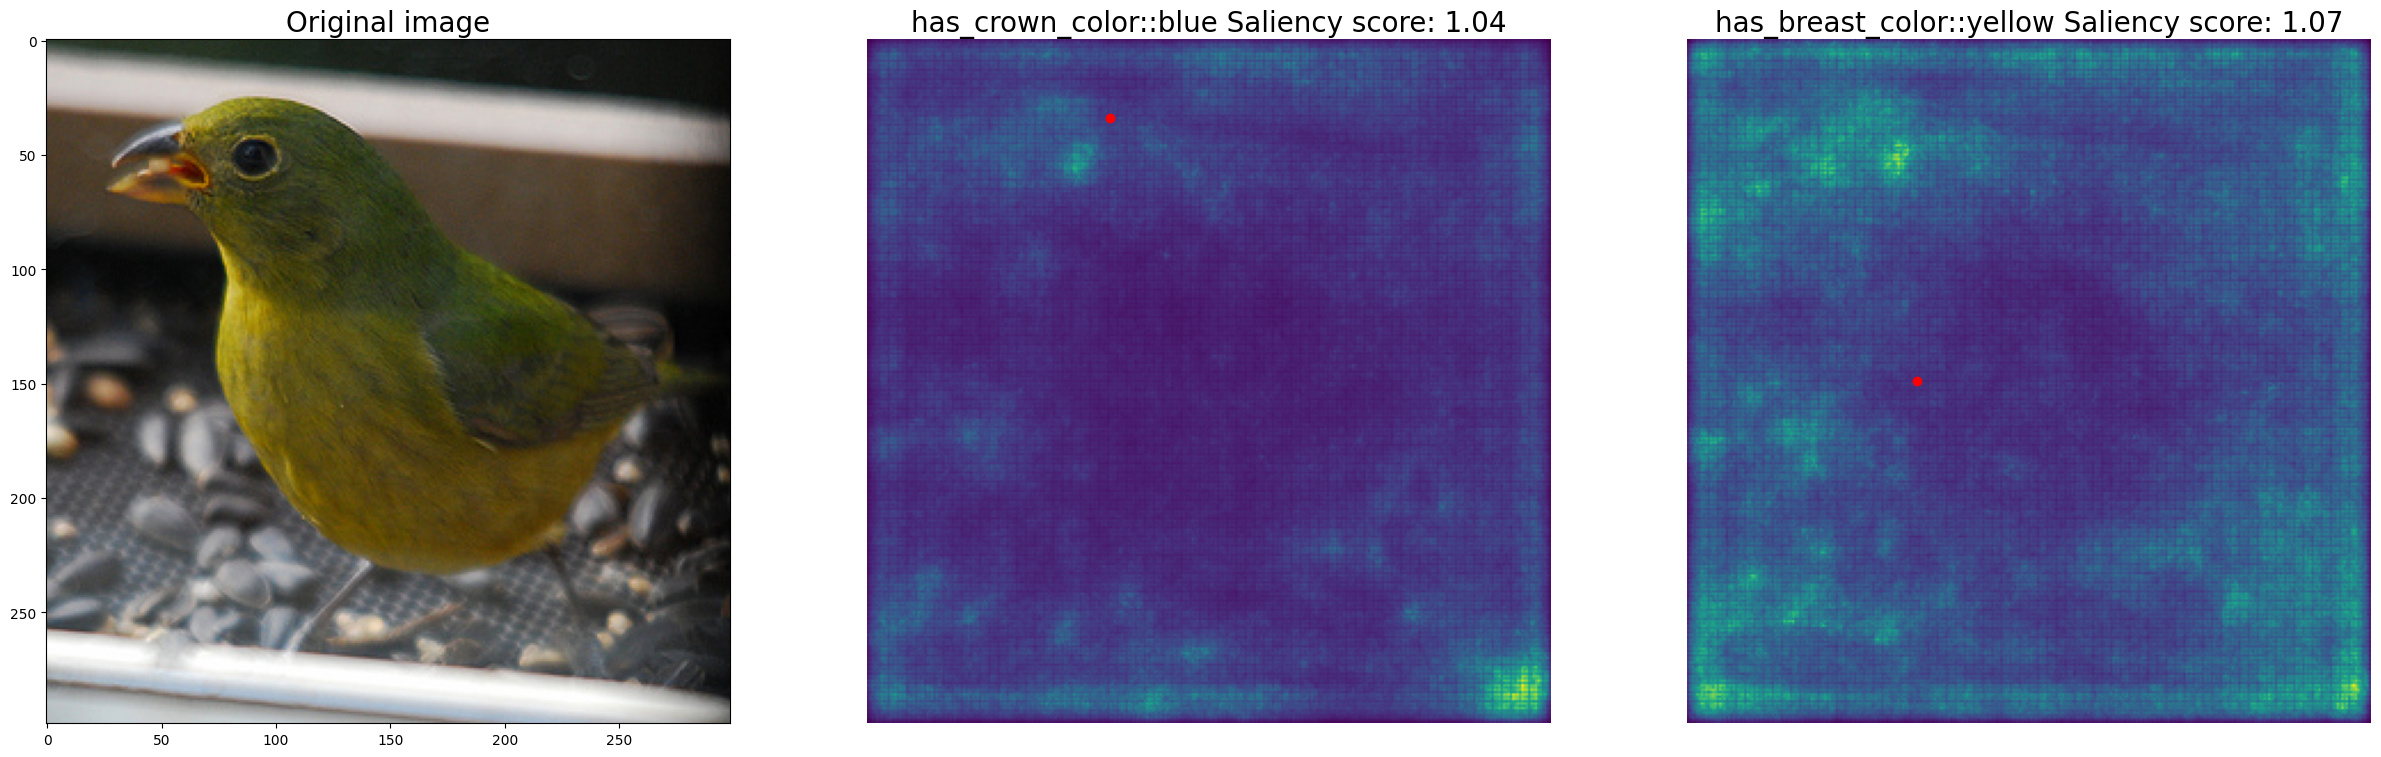

In [17]:
concept_list = [102,41]#,102,41]
Joint_model = torch.load(r'evaluate_models\Joint_CKPT_Majority\best_Joint_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model = Joint_model.XtoC_model
XtoC_Model.eval()
sailency_maps = get_saliency_maps(X,concept_list,XtoC_Model,method_type='noise_tunnel')

plot_sailency(img,sailency_maps,concept_list,concept_names,coordinates)

In [18]:

XtoC_Model = torch.load(r'evaluate_models\Concepts_CKPT_Majority\best_XtoC_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model.eval()
sailency_maps = get_saliency_maps(X,concept_list,XtoC_Model,method_type='noise_tunnel')

plot_sailency(img,sailency_maps,concept_list,concept_names,coordinates)

KeyboardInterrupt: 

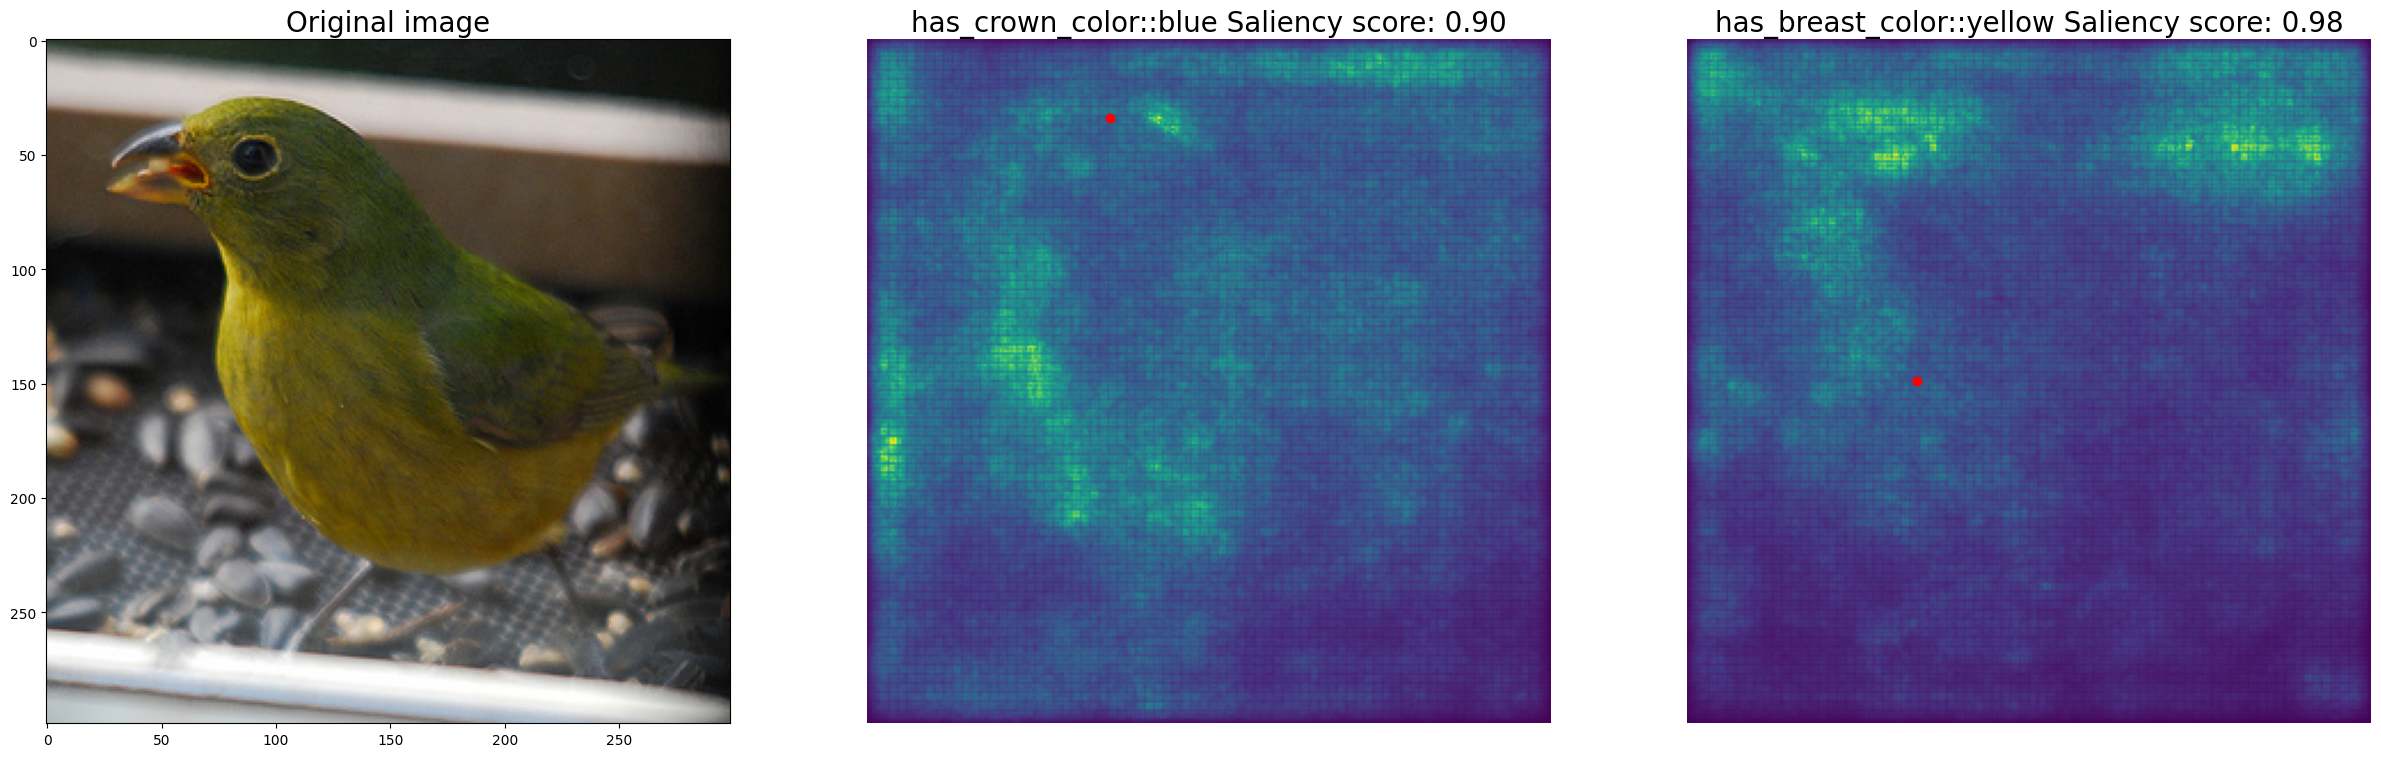

In [19]:
#concept_list = [39,8,51]
XtoC_Model = torch.load(r'evaluate_models\Concepts_CKPT_NoMajority\best_XtoC_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model.eval()
sailency_maps = get_saliency_maps(X,concept_list,XtoC_Model,method_type='noise_tunnel')

plot_sailency(img,sailency_maps,concept_list,concept_names,coordinates)

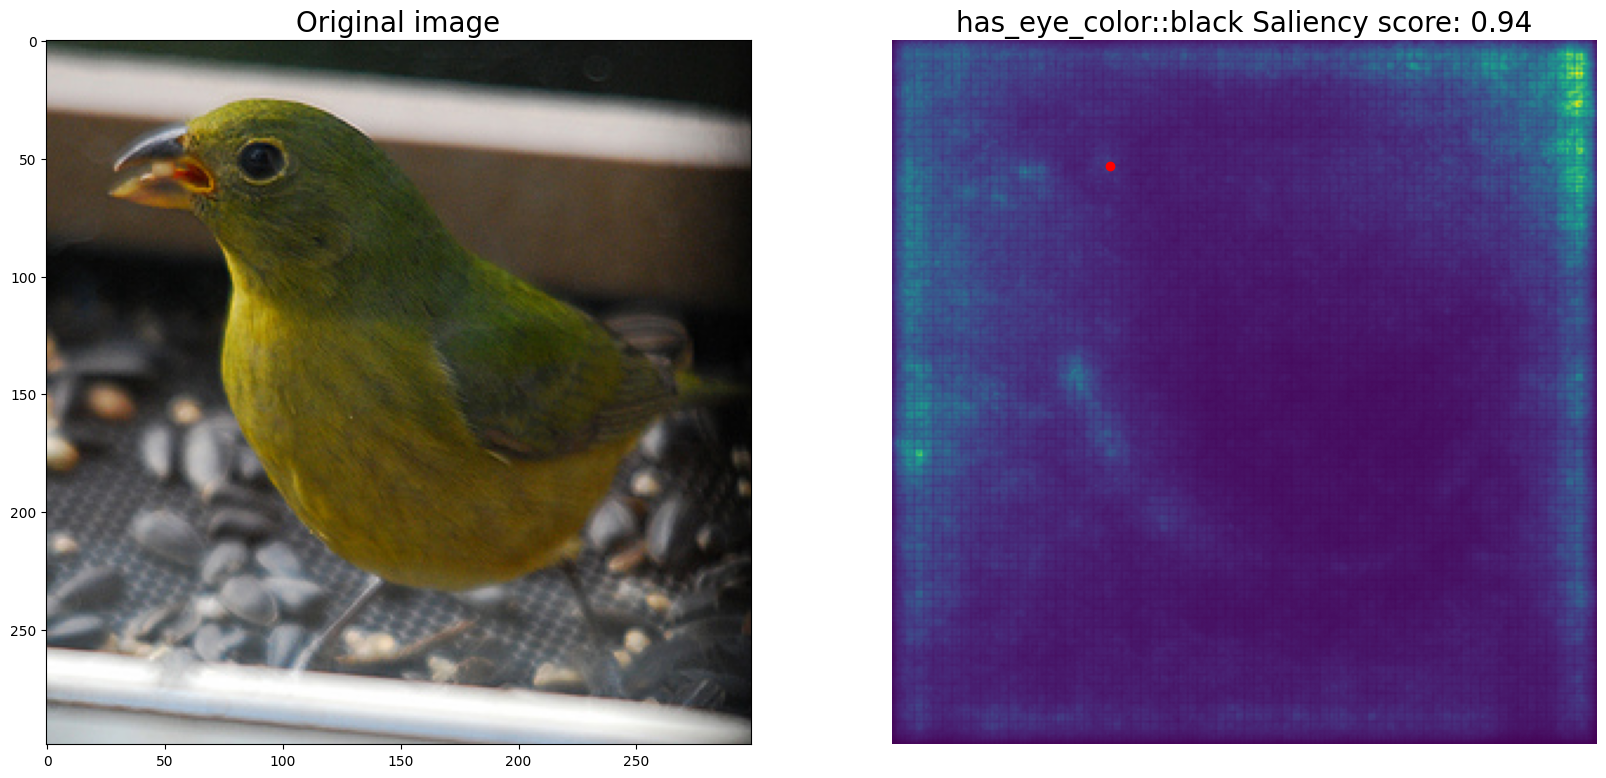

In [20]:
concept_list = [50]
XtoC_Model = torch.load(r'evaluate_models\Concepts_CKPT_Majority\best_XtoC_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model.eval()
sailency_maps = get_saliency_maps(X,concept_list,XtoC_Model,method_type='noise_tunnel')

plot_sailency(img,sailency_maps,concept_list,concept_names,coordinates)

In [14]:
#print full df
display_scrollable_dataframe(Full_df.sort_values(by=['Majority Label',"Label"],ascending=False))

In [22]:
print(Selected_df.to_latex(index=False))

\begin{tabular}{lrrrrrrrrr}
\toprule
Concept & Label & Majority Label & Wabler Majority & Joint MV & Joint NoN-MV & Sequential MV & Sequential NoN-MV & NoN-MV Label distribution & MV label ditribution \\
\midrule
has_bill_shape::all-purpose & False & False & True & 0.570000 & 0.620000 & 0.940000 & 0.690000 & 0.391754 & 0.405000 \\
has_bill_shape::cone & True & True & False & 0.720000 & 0.230000 & 0.020000 & 0.180000 & 0.261452 & 0.245000 \\
has_breast_color::yellow & True & False & True & 0.890000 & 0.790000 & 1.000000 & 0.830000 & 0.136834 & 0.145000 \\
has_forehead_color::blue & False & True & False & 0.400000 & 0.000000 & 0.010000 & 0.000000 & 0.050814 & 0.050000 \\
has_belly_color::yellow & True & False & True & 0.900000 & 0.620000 & 1.000000 & 0.770000 & 0.143536 & 0.145000 \\
has_back_pattern::solid & False & False & True & 0.010000 & 0.450000 & 0.630000 & 0.310000 & 0.365032 & 0.495000 \\
has_back_pattern::multi-colored & True & True & False & 1.000000 & 0.320000 & 0.400000 & 0.

In [23]:
display_scrollable_dataframe(Full_df)

In [24]:
df=pd.DataFrame(Concept_dict).sort_values(by=['Majority Label',"Label"],ascending=False)
latex_table = df.to_latex(index=False)
print(latex_table)

\begin{tabular}{lrrrrrrrrr}
\toprule
Concept & Label & Majority Label & Wabler Majority & Joint MV & Joint NoN-MV & Sequential MV & Sequential NoN-MV & NoN-MV Label distribution & MV label ditribution \\
\midrule
has_bill_shape::cone & True & True & False & 0.720000 & 0.230000 & 0.020000 & 0.180000 & 0.261452 & 0.245000 \\
has_eye_color::black & True & True & True & 1.000000 & 0.890000 & 1.000000 & 0.930000 & 0.837462 & 0.960000 \\
has_bill_length::shorter_than_head & True & True & True & 1.000000 & 0.850000 & 1.000000 & 0.810000 & 0.561079 & 0.630000 \\
has_back_pattern::multi-colored & True & True & False & 1.000000 & 0.320000 & 0.400000 & 0.250000 & 0.194774 & 0.070000 \\
has_leg_color::grey & True & True & False & 0.780000 & 0.290000 & 0.050000 & 0.310000 & 0.255599 & 0.225000 \\
has_bill_color::grey & True & True & True & 0.680000 & 0.530000 & 0.820000 & 0.640000 & 0.273583 & 0.125000 \\
has_wing_pattern::multi-colored & True & True & False & 1.000000 & 0.270000 & 0.360000 & 0.330